# Assignment 2 : Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the x and y coordinates) of 15 2D keypoints, such as left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

The project builds upon a baseline model designed to provide an initial solution for this task. From there, the objective is to design and implement a more robust and efficient model by introducing various improvement (data augmentation , optimization techniques , regularization methods, etc.)

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import os
import time
from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# loading data
from google.colab import drive
drive.mount('/content/drive')

FTRAIN = '/content/drive/My Drive/training.csv'
FTEST = '/content/drive/My Drive/test.csv'

def load(test = False, cols = None):

    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    df = df.dropna()  # drop all rows that have missing values in them
    print("\n")

    X = np.row_stack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    print("Number of samples in", fname, ":",len(X))
    print("Labels: ", df.columns.tolist())

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None
    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




Number of samples in /content/drive/My Drive/training.csv : 2140
Labels:  ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']

 Sample image with labels:


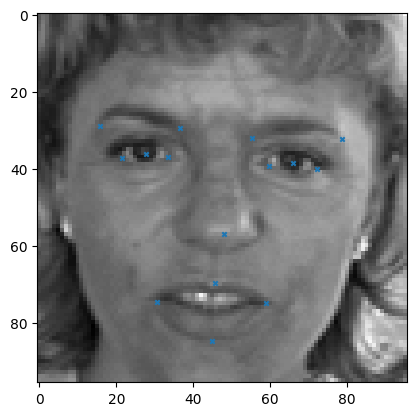

In [ ]:
# loading data

X, y = load()

print("\n Sample image with labels:")
plot_sample(X[15],y[15])

In [ ]:
# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_valid = np.expand_dims(x_valid, -1)
x_test = np.expand_dims(x_test, -1)

print(f'Training set x :{x_train.shape}')
print(f'Training set y :{y_train.shape}')
print(f'Validation set x: {x_valid.shape}')
print(f'Validation set y: {y_valid.shape}')
print(f'Test set x :{x_test.shape}')

Training set x :(1498, 96, 96, 1)
Training set y :(1498, 30)
Validation set x: (321, 96, 96, 1)
Validation set y: (321, 30)
Test set x :(321, 96, 96, 1)


## My solution

In [ ]:
from scipy.ndimage import gaussian_filter

def data_augmentation(x, y, numImg, horizontal=False, drop_out=True, perc=0.05, scaling=True, scale_range=(0.8, 1.2), target_size=(96, 96)):
    # Define columns for keypoints
    columns = ["left_eye_center_x", "left_eye_center_y", "right_eye_center_x", "right_eye_center_y",
               "left_eye_inner_corner_x", "left_eye_inner_corner_y", "left_eye_outer_corner_x", "left_eye_outer_corner_y",
               "right_eye_inner_corner_x", "right_eye_inner_corner_y", "right_eye_outer_corner_x", "right_eye_outer_corner_y",
               "left_eyebrow_inner_end_x", "left_eyebrow_inner_end_y", "left_eyebrow_outer_end_x", "left_eyebrow_outer_end_y",
               "right_eyebrow_inner_end_x", "right_eyebrow_inner_end_y", "right_eyebrow_outer_end_x", "right_eyebrow_outer_end_y",
               "nose_tip_x", "nose_tip_y", "mouth_left_corner_x", "mouth_left_corner_y", "mouth_right_corner_x",
               "mouth_right_corner_y", "mouth_center_top_lip_x", "mouth_center_top_lip_y", "mouth_center_bottom_lip_x",
               "mouth_center_bottom_lip_y"]

    # Create copies of the original dataset
    x_train_augmented = np.copy(x)
    y_train_augmented = np.copy(y)

    for i in range(numImg):
        image, labels = x[i], y[i]

        # Flip image horizontally if horizontal is True
        flipped_image_h = None  # Initialize to avoid reference before assignment
        if horizontal:
            flipped_image_h = tf.image.flip_left_right(image).numpy()

            # Adjust keypoints for flipped image
            flipped_labels_h = np.copy(labels)
            flipped_labels_h = flipped_labels_h.reshape((-1, 2))
            flipped_labels_h[:, 0] = -flipped_labels_h[:, 0]
            flipped_labels_h = flipped_labels_h.flatten()

            # Swap left and right keypoints
            left_idx = [i for i, el in enumerate(columns) if 'left' in el]
            right_idx = [i for i, el in enumerate(columns) if 'right' in el]
            flipped_labels_h[left_idx], flipped_labels_h[right_idx] = flipped_labels_h[right_idx], flipped_labels_h[left_idx]

            # Add flipped image to augmented dataset
            x_train_augmented = np.append(x_train_augmented, [flipped_image_h], axis=0)
            y_train_augmented = np.append(y_train_augmented, [flipped_labels_h], axis=0)

        # Apply Gaussian blur
        blurred_image = gaussian_filter(image, sigma=np.random.uniform(0.5, 1.5))

        # Apply brightness adjustments (darker)
        darkened_img = tf.image.adjust_brightness(image, delta=np.random.uniform(-1, 0)).numpy()

        # Apply brightness adjustments (lighter)
        lighter_img = tf.image.adjust_brightness(image, delta=np.random.uniform(0, 1)).numpy()

        # Apply scaling
        if scaling:
            scale_factor = np.random.uniform(scale_range[0], scale_range[1])
            scaled_image = tf.image.resize(image, (int(image.shape[0] * scale_factor), int(image.shape[1] * scale_factor)))
            scaled_image = tf.image.resize(scaled_image, target_size).numpy()

        # Add augmented images to dataset
        x_train_augmented = np.append(x_train_augmented, [blurred_image, darkened_img, lighter_img], axis=0)
        y_train_augmented = np.append(y_train_augmented, [labels, labels, labels], axis=0)

        # Apply dropout (random pixel drop)
        if drop_out:
            num_pixels = int((image.shape[0] ** 2) * perc)
            indices_x = np.random.randint(0, image.shape[0], num_pixels)
            indices_y = np.random.randint(0, image.shape[1], num_pixels)
            drop_out_image = np.copy(image)
            drop_out_image[indices_x, indices_y, :] = 0
            x_train_augmented = np.append(x_train_augmented, [drop_out_image], axis=0)
            y_train_augmented = np.append(y_train_augmented, [labels], axis=0)

    print(f'Training set after x :{x_train_augmented.shape}')
    print(f'Training set after y :{y_train_augmented.shape}')

    # Display augmented images (solo quelle desiderate)
    augmented_images = [image, blurred_image, darkened_img, lighter_img, drop_out_image, scaled_image]
    augmented_titles = ['Original', 'Blurred', 'Darkened', 'Lightened', 'Dropout', 'Scaled']

    # Visualize augmented images in a 2x3 grid
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 columns
    axes = axes.ravel()  # Flatten the axes array for easier indexing

    # Loop through the augmented images and titles to display them
    for i in range(len(augmented_images)):
      axes[i].imshow(np.squeeze(augmented_images[i]), cmap='gray')
      axes[i].set_title(augmented_titles[i])
      axes[i].axis('off')  # Hide the axis

    # Adjust the layout to avoid overlapping
    plt.tight_layout()
    plt.show()


    return x_train_augmented, y_train_augmented


Training set after x :(8988, 96, 96, 1)
Training set after y :(8988, 30)


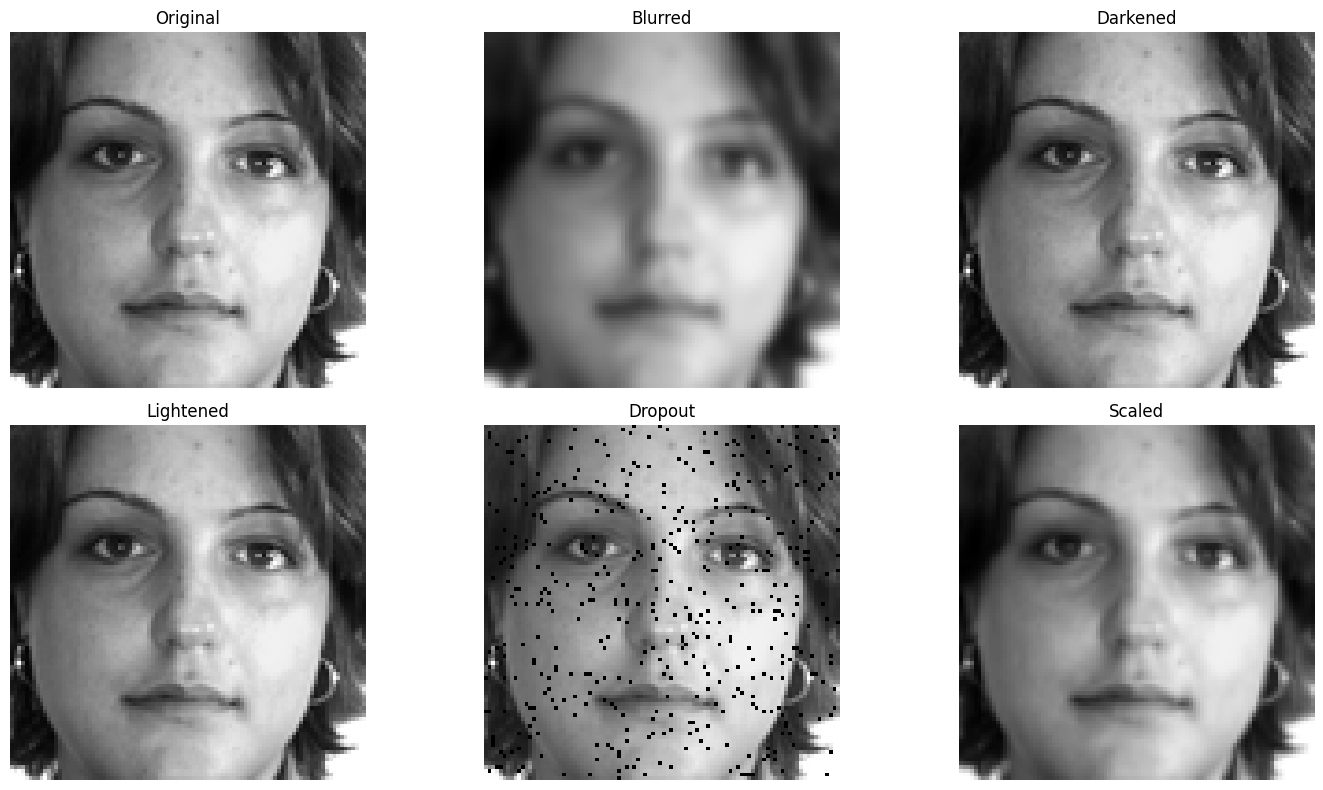

In [ ]:
# # Get the number of images in the training set
numImg = x_train.shape[0]

# # Apply data augmentation function to generate augmented training data

x_train_augmented, y_train_augmented = data_augmentation(
    x_train, y_train, numImg,
    horizontal=True, drop_out=True,
    perc=0.05, scaling=True)

In [ ]:
#NEW MODEL

# Hyperparameters
batch_size = 32
epochs = 500
input_shape = (96, 96, 1)
output_shape = 30

# Define a Sequential model
model = keras.Sequential(
    [
        # Input layer with specified input shape
        keras.Input(shape=input_shape),
        # Batch normalization to normalize activations
        layers.BatchNormalization(),

        # Feature extraction layers
        layers.Conv2D(16, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.AveragePooling2D(pool_size=(2, 2)),

        layers.Conv2D(32, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.AveragePooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.AveragePooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.AveragePooling2D(pool_size=(2, 2)),

        # Global Average Pooling to summarize spatial information
        layers.GlobalAveragePooling2D(),

        # Regression layers
        layers.Flatten(),
        layers.Dense(512, activation="relu"),

        # Dropout layer for regularization
        layers.Dropout(0.5),

        layers.Dense(90, activation="relu"),

        # Output layer with linear activation for regression
        layers.Dense(output_shape, activation="tanh"),
    ]
)


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_1                │ (None, 96, 96, 1)           │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 96, 96, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_4                  │ (None, 48, 48, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 48, 48, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_5                  │ (None, 24, 24, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 24, 24, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_6                  │ (None, 12, 12, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_7                  │ (None, 6, 6, 128)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 90)                  │          46,170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 30)                  │           2,730 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 384,392 (1.47 MB)

 Trainable params: 384,390 (1.47 MB)

 Non-trainable params: 2 (8.00 B)

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Define a custom loss class for Root Mean Squared Error
class RootMeanSquaredError(tf.Module):
    def __init__(self):
        super().__init__()

    def __call__(self, y_true, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

    def get_config(self):
        # No additional configuration is needed
        return {}

# Create an instance of the custom loss
root_mean_squared_error = RootMeanSquaredError()

# Compile the model with the custom loss, Adam optimizer, and accuracy metric
model.compile(
    loss=root_mean_squared_error,
    optimizer="adam",
    metrics = ['accuracy']
)

# Set up early stopping with patience and restoring best weights
es = EarlyStopping(monitor='val_loss', mode='auto', patience=10,  restore_best_weights=True)

# Train the model with augmented data and early stopping
history = model.fit(
    x_train_augmented, y_train_augmented,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[es]
)

Epoch 1/500
253/253 ━━━━━━━━━━━━━━━━━━━━ 34s 116ms/step - accuracy: 0.5751 - loss: 0.1242 - val_accuracy: 0.7686 - val_loss: 0.0704
Epoch 2/500
253/253 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6937 - loss: 0.0689 - val_accuracy: 0.7686 - val_loss: 0.0698
Epoch 3/500
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6868 - loss: 0.0681 - val_accuracy: 0.7686 - val_loss: 0.0680
Epoch 4/500
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6913 - loss: 0.0640 - val_accuracy: 0.7686 - val_loss: 0.0660
Epoch 5/500
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6955 - loss: 0.0591 - val_accuracy: 0.7742 - val_loss: 0.0576
Epoch 6/500
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6930 - loss: 0.0541 - val_accuracy: 0.7742 - val_loss: 0.0508
Epoch 7/500
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7171 - loss: 0.0467 - val_accuracy: 0.7964 - val_loss: 0.0463
Epoch 8/500
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7392 - loss: 0.0430 - val_

In [ ]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Mean pixel error:  1.2887934


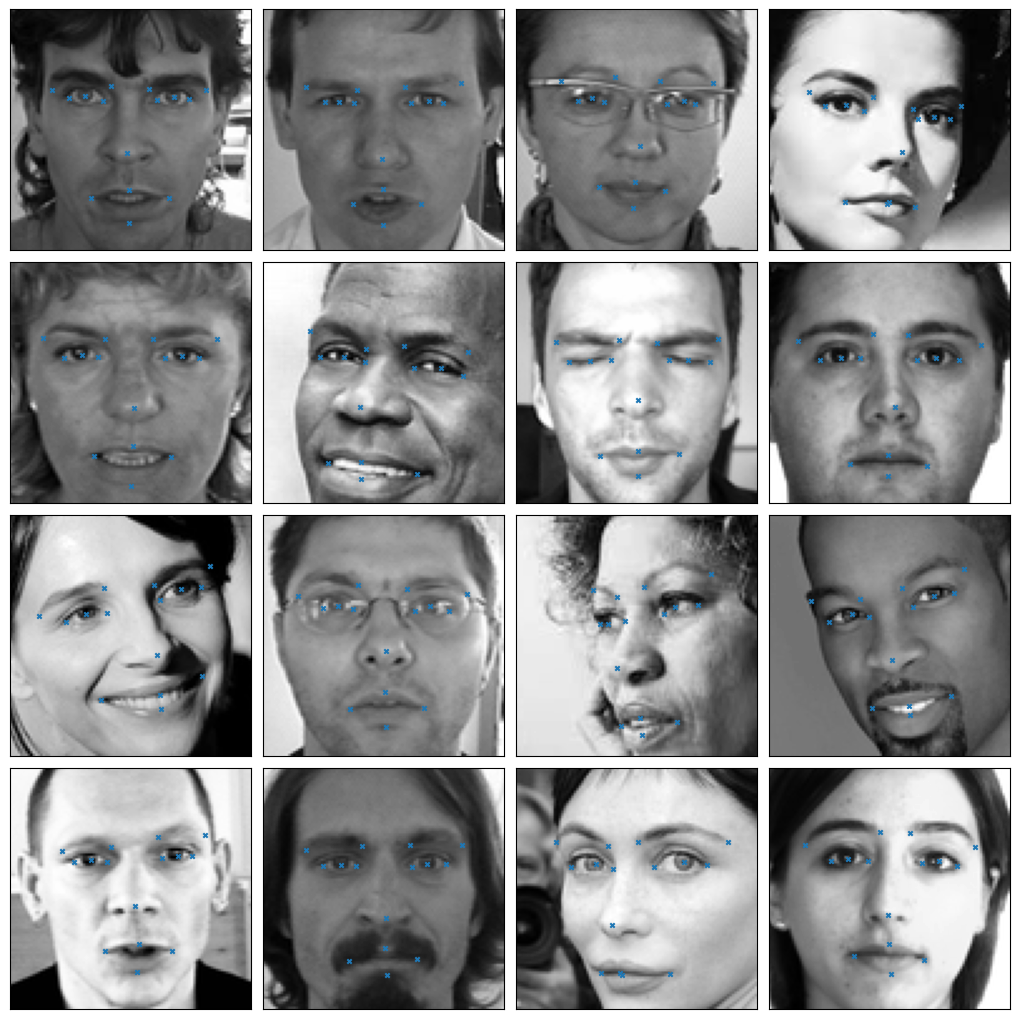

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

## What is the best result you got when testing?  

**Answer**: The mean pixel error is 1.2887

## What architecture and tricks you used for that result?
### Describe your design strategy as well all those tricks that contributed to your result.

**Answer**:

In my project, I focused on improve the baseline model's performance by applying data augmentation techniques and creating a more structured neural network architecture.

**Data Augementation**

As for data augmentation, its goal is to artificially expand the training dataset by applying various transformations to the original data. This helps the model become more robust and generalize better to new data.

To start, I implemented image flipping, both horizontally and vertically, which allowed me to create mirror images of the input data. However, after some experimentation, I decided to remove vertical flipping, as it did not positively impact the model's accuracy.

Next, I incorporated some transformations to simulate different lighting conditions (both darker and lighter), and I introduced Gaussian blur to create slightly blurry images.

After experimenting with various augmentation techniques such as rotation, zooming, shearing, scaling, and dropout (random pixel removal), I found that dropout and scaling were the most effective techniques, so I decided to add only these two methods.

**Model Architecture**
In order to obtain a more structured neural network architecture I chose a deep convolutional neural network (CNN) using Keras' Sequential API.

I began by adding a Batch Normalization layer to make training more stable and faster. Then, I added several convolutional layers with progressively larger filter sizes (16, 32, 64, and 128), each followed by an AveragePooling layer. This helped the network to find more important patterns in the images. At the same time, the pooling layers made the images smaller, keeping only the most useful information.I also tried MaxPooling and different kernel sizes during the design process, and in the end, I chose this setup because it worked the best.

To help the model learn complex patterns, I used the ReLU activation function in all the convolutional layers. This function adds non-linearity and helps the model learn better during training. After the convolutional layers, I added a Global Average Pooling layer. This layer reduces overfitting and makes the model simpler by summarizing the spatial information.

Finally, I added two fully connected (dense) layers. The first one has 512 neurons, and the second one has 90 neurons. I also included a Dropout layer before the final output layer with a 0.5 rate to help reduce overfitting by randomly turning off some neurons during training. The output layer is a dense layer with 30 units and uses the "tanh" activation function, which works well for predicting continuous values.I also tried using a linear activation function, but found that 'tanh' gave better results in this case.

During training, I tested different optimizers and found that Adam performed better, providing faster convergence and more stable updates.

In conclusion, using data augmentation and building a good deep learning model helped the algorithm perform well, with a mean pixel error of 1.29. This shows how important it is to experiment step by step, always improving both the data and the model to get better results.